In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

from kernel import *
from MMD import *
from feedback import *

%load_ext autoreload
%autoreload 2

# Question 2 : Data generation

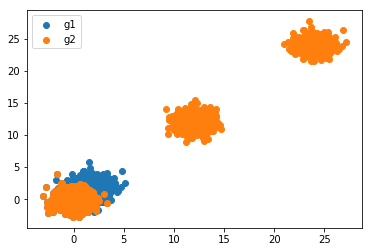

In [2]:
def gaussian_mix(d,N,t,n,s=1, seed=1):
    np.random.seed(seed)
    cov = np.identity(d)
    mean = np.zeros(d)
    n_tot = N*n
    res = np.zeros((d,n_tot))
    for i in range(N):
        gaus = np.random.multivariate_normal(mean + t*i, cov*(s**i),n).T
        for j in range(d):
            res[j][i*n:(i+1)*n] = gaus[j]
            
    return(res)  

g1 = gaussian_mix(d=2,N=3,t=1,n=500, seed=1) 
g2 = gaussian_mix(d=2,N=3,t=12,n=500, seed=1) 

plt.scatter(g1[0], g1[1], label="g1")
plt.scatter(g2[0], g2[1], label="g2")
plt.legend()
plt.show()

# Question 3 : MMD and type I error

The MMD test is now implemented.

#### TODO : Propose a strategy to check whether MMD is a test of level α. Then, present experiments on the gaussian data. Discuss the results.

The level alpha of a test is an upper bound of the probability of type I error (rejecting H0 while it is true).
A TST of level alpha using MMD as test statistic has the acceptance region  : MMD <= sqrt(2K/m) (1 + sqrt(2log(1/alpha))).
We have to check if the probability of rejecting H0 while it is true (type I error) with the MMD TST is upper-bounded by alpha.

In [3]:
%%time
kernel_class = GaussianKernel()
test = MMD_test(kernel_class=kernel_class, alpha=0.05, biased=True)

test.fit(X=g1, Y=g2, verbose=True)
test.get_results()

MMD test of level alpha=0.05, biased=True estimator
Kernel: Gaussian Kernel with sigma=1
Result: H0 rejected, test statistic=0.448491693291057 > threshold=0.1258939141153885
Wall time: 384 ms


In [11]:
N = 100
res = []
kernel_class = GaussianKernel()
for i in range(N):
    g1 = gaussian_mix(d=2,N=3,t=1,n=500, seed=1) 
    g2 = gaussian_mix(d=2,N=3,t=1,n=500, seed=1) 

    test = MMD_test(kernel_class=kernel_class, alpha=0.05, biased=True)

    test.fit(X=g1, Y=g2, verbose=False)
    res.append(test.test_result)

err = [x for x in res if x == 'rejected']
p = len(err)/N
p

0.0

In [23]:
N = 10
res = []
kernel_class = GaussianKernel()
for i in range(N):
    g1 = gaussian_mix(d=2,N=3,t=1,n=500, seed=1) 
    g2 = gaussian_mix(d=2,N=3,t=1,n=500, seed=1) 

    test = MMD_test(kernel_class=kernel_class, alpha=0.05, biased=True)

    test.fit(X=g1, Y=g2, verbose=False)
    res.append(test.T-test.threshold)

y = [x for x  in res if x <= 0]
len(y)/N

1.0

par def du test, on a mis le threshold tel que le niveau soit alpha....

In [18]:
g1 = gaussian_mix(d=2,N=3,t=1,n=500, seed=1) 
g2 = gaussian_mix(d=2,N=3,t=1.1,n=500, seed=1) 
test = MMD_test(kernel_class=kernel_class, alpha=0.05, biased=True)
test.fit(X=g1, Y=g2, verbose=True)
   

MMD test of level alpha=0.05, biased=True estimator
Kernel: Gaussian Kernel with sigma=1
Result: H0 accepted, test statistic=0.03881446934016507 <= threshold=0.1258939141153885


#### Verification with old implementation

In [4]:
from itertools import product   

def gauss_kernel(x,y,s=1):
    k = np.exp(-sum((x-y)**2)/(2*(s**2)))
    return k

def threshold(n,alpha=0.05):  # gauss kernel <=1, K = 1
    t = np.sqrt(2/n)*(1+np.sqrt(2*np.log(1/alpha)))  #need n=m
    return(t)

def MMD2(g1,g2): # moins long ?
    n = len(g1[0])
    m = len(g2[0])
    
    mmd1 = [gauss_kernel(g1.T[i],g1.T[j])/n**2 for i,j in product(range(n),range(n))]
    mmd2 = [gauss_kernel(g2.T[i],g2.T[j])/m**2 for i,j in product(range(m),range(m))]
    mmd3 = [-2*gauss_kernel(g1.T[i],g2.T[j])/(m*n) for i,j in product(range(n),range(m))]
    
    MMD = np.sqrt(sum(mmd1) + sum(mmd2) + sum(mmd3))
    
    return(MMD) 

    
def TST_MMD(g1,g2,alpha=0.05):
    if len(g1) != len(g2):
        print('data must have the same dimension')
        mmd = 0
        t=0

    if len(g1[0]) != len(g1[0]):
        print('data must have the same number of points')
        mmd = 0
        t = 0

    if len(g1) == len(g2) and len(g1[0]) == len(g1[0]) :
        mmd = MMD2(g1,g2)
        t = threshold(len(g1[0]), alpha)
        if mmd <= t:
            print('H0 accepted at level',alpha)
        else:
            print('H0 rejected at level',alpha)
    
    return mmd, t

In [5]:
%%time
TST_MMD(g1,g2)

H0 rejected at level 0.05
Wall time: 2min 7s


(0.44849169329103433, 0.1258939141153885)

# Question 4 : TST versus feedback under the null hypothesis.

Sources : 
+ the course notes (1 Introduction to statistical hypothesis testing and two-sample tests),  
+ B. Phipson and G.K. Smyth "Permutation p-values should never be zero: calculating exact p- values when permutations are randomly drawn.", Statistical Applications in Genetics and Molecular Biology, 9(1), 2010, and the SBL library

Course notes eq 1.19 defines $b$ as the test statistic : it is the number of random datasets yielding a test statistic larger than that obtained
on the observed dataset. Section 1.6.4 with eq 1.25 defines the p_value as $\hat{p} = \frac{b+1}{I + 1}$ (NB : `I` is `m` in the code following the notations from Phipson & Al.) in the case of a permutation test with no replacement.

The JSD of each dataset will be taken as the average JSD of each point.

The algorithm is as follows : 
1. Compute JSD using original labels
2. Until `n_permutations` different permutations is done:
    + Compute a new permutation over labels
    + Check if it is a new permutation
    + if yes : estimate JSD
3. $b = \sum_{permutation} \mathbb{1}_{JSD_{permutation} > JSD_{obs}}$
4. $p = \frac{b+1}{n_{permutations} + 1}$
5. Test result : accept if $p > \alpha$ else reject

We follow `sbl-ddbc-step-1-discrepancy.py` for computing local JSD but the subsample module in `random_device` is not used : permutation is rewritten.

Under $H_0$ : test should be accepted

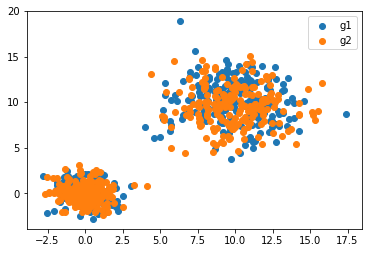

Feedback test of level alpha=0.05
Number of permutations=50
jsd_obs=0.015571730825168521, mean jsd_permutations=0.012853614982934214
Result: H0 accepted, test statistic=8, p_value=0.17647058823529413 >= alpha=0.05
Wall time: 1.74 s


In [6]:
%%time
###################### PARAMETERS ########################
n_permutations = 50  # number of permutation tests
g1 = gaussian_mix(d=2,N=2,t=10,n=200, s=5, seed=1) 
g2 = gaussian_mix(d=2,N=2,t=10,n=200, s=5, seed=2)  # should be identical to g1 except for random seed
##########################################################
plt.scatter(g1[0], g1[1], label="g1")
plt.scatter(g2[0], g2[1], label="g2")
plt.legend()
plt.show()

rd.seed(0)
kofn_power = 0.66
fk = DDBC_feedback(
    g1, g2,
)
fk.permutation_test(n_permutations=n_permutations)
print(fk)

# Question 5 : TST versus feedback under the alternative

Under $H_1$ : test should be rejected

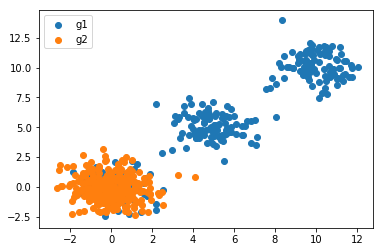

Feedback test of level alpha=0.05
Number of permutations=50
jsd_obs=0.45222371256371524, mean jsd_permutations=0.014271674090087958
Result: H0 rejected, test statistic=0, p_value=0.0196078431372549 < alpha=0.05
Wall time: 1.77 s


In [7]:
%%time
###################### PARAMETERS ########################
n_permutations = 50  # number of permutation tests
g1 = gaussian_mix(d=2,N=3,t=5,n=100, s=1, seed=1) 
g2 = gaussian_mix(d=2,N=3,t=0,n=100, s=1, seed=2)  # should be different from g1
##########################################################

plt.scatter(g1[0], g1[1], label="g1")
plt.scatter(g2[0], g2[1], label="g2")
plt.legend()
plt.show()

rd.seed(0)
kofn_power = 0.66
fk = DDBC_feedback(
    g1, g2,
)
fk.permutation_test(n_permutations=n_permutations)
print(fk)

### Comparison of the variation of the test statistic of MMD, and that of the JS divergence returned by the feedback

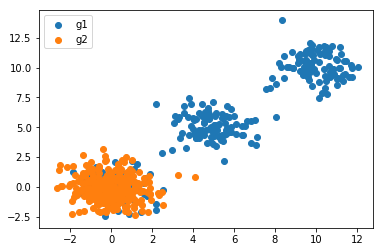

JSD Test statistic
0
MMD Test statistic
0.45602427920900546
Wall time: 1.23 s


In [12]:
%%time
###################### PARAMETERS ########################
n_permutations = 50  # number of permutation tests
g1 = gaussian_mix(d=2,N=3,t=5,n=100, s=1, seed=1) 
g2 = gaussian_mix(d=2,N=3,t=0,n=100, s=1, seed=2)  # should be different from g1
##########################################################

plt.scatter(g1[0], g1[1], label="g1")
plt.scatter(g2[0], g2[1], label="g2")
plt.legend()
plt.show()

rd.seed(0)
kofn_power = 0.66
fk = DDBC_feedback(
    g1, g2,
)
fk.permutation_test(n_permutations=n_permutations)
print('JSD Test statistic')
print(fk.b)

kernel_class = GaussianKernel()
test = MMD_test(kernel_class=kernel_class, alpha=0.05, biased=True)

test.fit(X=g1, Y=g2, verbose=False)
print('MMD Test statistic')
print(test.T)

In [13]:
def compare(g1,g2):
    
    #JSD
    rd.seed(0)
    kofn_power = 0.66
    fk = DDBC_feedback(
        g1, g2,
    )
        
    fk.permutation_test(n_permutations=n_permutations)

    #MMD
    kernel_class = GaussianKernel()
    test = MMD_test(kernel_class=kernel_class, alpha=0.05, biased=True)

    test.fit(X=g1, Y=g2, verbose=False)

    return fk.b, test.T

In [38]:
l_j = []
l_m = []

g2 = gaussian_mix(d=2,N=3,t=0,n=100, s=1, seed=2)
for t in range(1,11):
    g1 = gaussian_mix(d=2,N=3,t=t*0.1,n=100, s=1, seed=1)
    comparison  = compare(g1,g2)
    l_j.append(comparison[0])
    l_m.append(comparison[1])
    
df = pd.DataFrame()
df['JSD'] = l_j
df['MMD'] = l_m
df['translation'] = range(1,11)
df['translation'] = df['translation']*0.1

In [39]:
df

,JSD,MMD,translation
0,0,0.124594,0.1
1,0,0.162645,0.2
2,0,0.199009,0.3
3,0,0.232830,0.4
4,0,0.263655,0.5
5,0,0.291260,0.6
6,0,0.315592,0.7
7,0,0.336733,0.8
8,0,0.354874,0.9
9,0,0.370281,1.0
